preprocesses image of shape (30, 36, 30, 291)


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

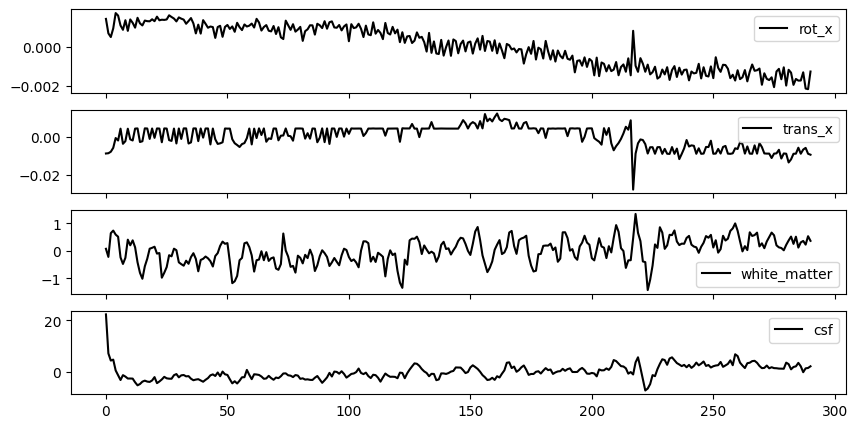

In [1]:
import numpy as np
import pandas as pd
from nilearn import image, interfaces, plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.maskers import NiftiMasker

# path to preprocessed data corresponding and task events: '*desc-preproc_bold.nii.gz', '*events.tsv'
preproc_path = "../fmriprep/sub-208_task-colorwheel_acq-multiband_run-1_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz"
mask_path = "../fmriprep/sub-208_task-samedifferent_acq-multiband_run-1_space-MNI152NLin6Asym_res-2_desc-brain_mask.nii.gz"
events_path = "../fmriprep/sub-208_task-colorwheel_acq-multiband_run-1_events.tsv"
preproc_img = image.load_img(preproc_path)  # downsampled to lower spatial resolution
print("preprocesses image of shape", preproc_img.shape)

# initialize a masker for the whole brain
masker = NiftiMasker(mask_img=mask_path)

# load subset of confounds calculated by fMRIPrep, from the corresponding '*desc-confounds_timeseries.tsv'
# select which subset by 'denoise_strategy' kwarg
confounds = interfaces.fmriprep.load_confounds_strategy(preproc_path, denoise_strategy="simple")[0]
confounds[["rot_x", "trans_x", "white_matter", "csf"]].plot(
    kind="line", subplots=True, sharex=True, sharey=False, figsize=(10, 5), color="k"
)

In [2]:
events = pd.read_csv(events_path, sep="\t", usecols=["onset", "duration"]).assign(
    trial_type="colorwheel"
)

glm = FirstLevelModel(
    t_r=2,
    mask_img=mask_path,  # include the brain mask
    hrf_model="glover + derivative",  # hemodynamic response function
    smoothing_fwhm=6,  # gaussian kernel width (in mm)
    drift_model=None,  # cosine drift terms already in confounds
    high_pass=None,  # drift terms equivalent to high-pass filter
    n_jobs=-2,  # use all-1 available CPUs
)
glm.fit(preproc_img, events, confounds)

FirstLevelModel(drift_model=None, fir_delays=[0], high_pass=None,
                hrf_model='glover + derivative',
                mask_img='../fmriprep/sub-208_task-samedifferent_acq-multiband_run-1_space-MNI152NLin6Asym_res-2_desc-brain_mask.nii.gz',
                memory=Memory(location=None), n_jobs=-2, smoothing_fwhm=6,
                t_r=2)

In [3]:
# design matrix = task (convolved with HRF) + confounds
glm.design_matrices_[0].columns

Index(['colorwheel', 'colorwheel_derivative', 'cosine00', 'cosine01',
       'cosine02', 'cosine03', 'cosine04', 'cosine05', 'cosine06', 'cosine07',
       'csf', 'rot_x', 'rot_x_derivative1', 'rot_x_derivative1_power2',
       'rot_x_power2', 'rot_y', 'rot_y_derivative1',
       'rot_y_derivative1_power2', 'rot_y_power2', 'rot_z',
       'rot_z_derivative1', 'rot_z_derivative1_power2', 'rot_z_power2',
       'trans_x', 'trans_x_derivative1', 'trans_x_derivative1_power2',
       'trans_x_power2', 'trans_y', 'trans_y_derivative1',
       'trans_y_derivative1_power2', 'trans_y_power2', 'trans_z',
       'trans_z_derivative1', 'trans_z_derivative1_power2', 'trans_z_power2',
       'white_matter', 'constant'],
      dtype='object')

map of parameter estimates of shape (30, 36, 30)


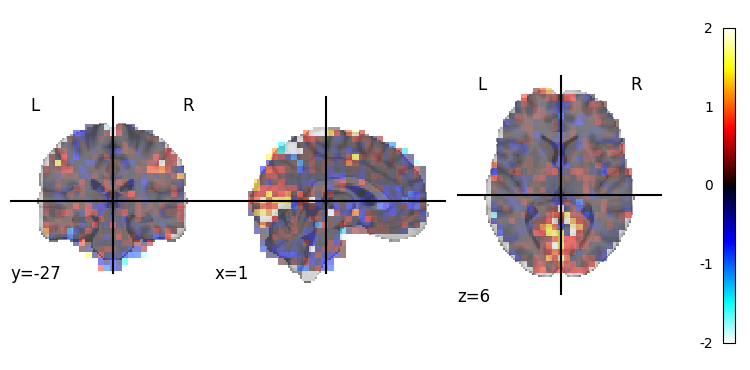

In [4]:
# map of parameter estimates / beta weights
# this is the 'feature' map to use in classification
params_ = glm.compute_contrast("colorwheel", output_type="effect_size")
print("map of parameter estimates of shape", params_.shape)

plotting.plot_stat_map(params_, vmax=2, alpha=0.5)

3D beta map: (30, 36, 30)
1D beta vector (only voxels inside the brain): (8698,)
3D weights map: (30, 36, 30)


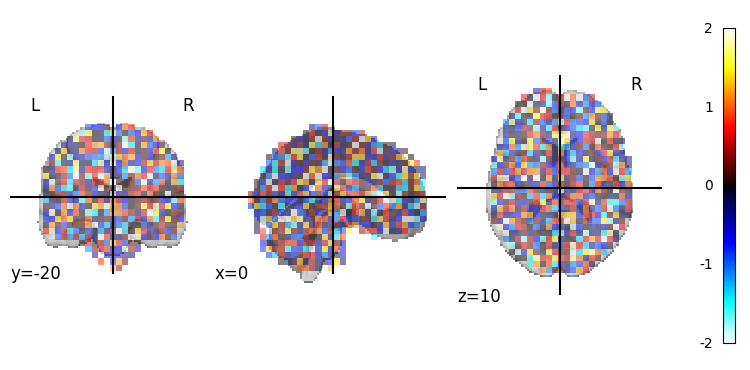

In [ ]:
params_1d = masker.fit_transform(params_).flatten()  # mask only voxels inside the brain
weights_1d = np.random.normal(size=params_1d.shape)  # random weights (ex from a classifier)
weights_3d = masker.inverse_transform(weights_1d)  # puts weights into 3d space for plotting

print("3D beta map:", params_.shape)
print("1D beta vector (only voxels inside the brain):", params_1d.shape)
print("3D weights map:", weights_3d.shape)

plotting.plot_stat_map(weights_3d, vmax=2, alpha=0.5)